Student Name: Zhiyi Ren

Analytic Goal: What features are important to decide whether the steam player will likely to 'voted up' the steam game, using models to predict whether a game review is 'voted up'

Machine Learning Algorithm: Decision Tree for Binary Classification Logistic Regression

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import re
from time import time
import string

In [0]:
%%time
spark = SparkSession.builder.config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1")\
                            .config("spark.network.timeout", "36000000000s")\
                            .config("spark.executor.heartbeatInterval", "36000000000s")\
                            .getOrCreate()

CPU times: user 2.48 ms, sys: 0 ns, total: 2.48 ms
Wall time: 18.4 ms

In [0]:
%%time
database = 'steam'
collection = 'steam'
user_name = 'renne'
password = 'renne'
address = 'gogogo.chu66.mongodb.net'
connection_string = f"mongodb+srv://{user_name}:{password}@{address}/{database}.{collection}"

CPU times: user 19 µs, sys: 4 µs, total: 23 µs
Wall time: 28.1 µs

In [0]:
%%time
df = spark.read.format("mongo").option("uri",connection_string).load()

CPU times: user 26.7 ms, sys: 5.17 ms, total: 31.8 ms
Wall time: 8.39 s

## Decision Tree

In [0]:
%%time
df_useful = df.drop("_id","appid","developer","name","owners",'release_date','review','timestamp_created','timestamp_updated','steamspy_tags','steamid').cache()
df_useful = df_useful.na.drop()

CPU times: user 5.51 ms, sys: 1.25 ms, total: 6.76 ms
Wall time: 366 ms

In [0]:
%%time
from pyspark.ml.feature import StringIndexer

def indexStringColumns(df, cols):
    # variable newdf will be updated several times
    newdf = df
    
    for c in cols:
        # For each given colum, fits StringIndexerModel.
        si = StringIndexer(inputCol=c, outputCol=c+"-num")
        sm = si.fit(newdf)
        
        # Creates a DataFame by putting the transformed values in the new colum with suffix "-num" 
        # and then drops the original columns.
        # and drop the "-num" suffix. 
        newdf = sm.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-num", c)
    return newdf

dfnumeric = indexStringColumns(df_useful, ["categories", "genres","platforms",'publisher'])

dfnumeric = dfnumeric.withColumn("voted_up",col("voted_up").cast("double"))

from pyspark.ml.feature import OneHotEncoder

def oneHotEncodeColumns(df, cols):
    newdf = df
    for c in cols:
        ohe = OneHotEncoder(inputCol=c, outputCol=c+"-onehot", dropLast=False)
        ohe_model = ohe.fit(newdf)

        newdf = ohe_model.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-onehot", c)
    return newdf

dfhot = oneHotEncodeColumns(dfnumeric, ["categories", "genres","platforms",'publisher']) 

from pyspark.ml.feature import VectorAssembler
input_cols=["achievements","average_playtime","english","median_playtime","negative_ratings","num_games_owned","num_reviews","playtime_at_review","playtime_forever","positive_ratings","price","required_age",'votes_up',"votes_funny",'weighted_vote_score','categories','genres','platforms','publisher']

va = VectorAssembler(outputCol="features", inputCols=input_cols)

lpoints = va.transform(dfhot).select("features", "voted_up").withColumnRenamed("voted_up", "label")

#Divide the dataset into training and vaildation sets.
splits = lpoints.randomSplit([0.8, 0.2])

#cache() : the algorithm is interative and training and data sets are going to be reused many times.
adulttrain = splits[0].cache()
adultvalid = splits[1].cache()

CPU times: user 374 ms, sys: 220 ms, total: 594 ms
Wall time: 1min 49s

In [0]:
%%time
adultvalid.show(3)

+--------------------+-----+
 features|label|
+--------------------+-----+
(6682,[0,1,2,3,4,...| 0.0|
(6682,[0,1,2,3,4,...| 1.0|
(6682,[0,1,2,3,4,...| 1.0|
+--------------------+-----+
only showing top 3 rows

CPU times: user 3.92 ms, sys: 1.12 ms, total: 5.04 ms
Wall time: 1.93 s

In [0]:
%%time
# Train the data.
from pyspark.ml.classification import DecisionTreeClassifier
# Paramenters
# maxDepth : maximum tree depth (default : 5).
# maxBins : maximum number of bins when binning continuous features (default : 32).
# minInstancesPerNode : minimum number of dataset samples 
#     each branch needs to have after a split (default : 1).
# minInfoGain : minimum information gain for a split (default : 0).
dt = DecisionTreeClassifier(maxDepth=10, maxBins= 32, minInstancesPerNode=1, minInfoGain = 0)
dtmodel = dt.fit(adulttrain)

CPU times: user 1.39 s, sys: 641 ms, total: 2.04 s
Wall time: 8min 47s

In [0]:
%%time
dtmodel.featureImportances
print(dtmodel.toDebugString)

dtpredicts = dtmodel.transform(adultvalid)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_bf5b0cb6cbfb, depth=10, numNodes=1099, numClasses=2, numFeatures=6682
 If (feature 12 <= 1.5)
 If (feature 8 <= 103.0)
 If (feature 13 <= 0.5)
 If (feature 10 <= 15.739999771118164)
 If (feature 8 <= 31.5)
 If (feature 12 <= 0.5)
 If (feature 4 <= 677.0)
 If (feature 9 <= 1742.5)
 If (feature 4 <= 176.5)
 Predict: 1.0
 Else (feature 4 > 176.5)
 If (feature 9 <= 580.5)
 Predict: 0.0
 Else (feature 9 > 580.5)
 Predict: 1.0
 Else (feature 9 > 1742.5)
 Predict: 1.0
 Else (feature 4 > 677.0)
 If (feature 9 <= 4644.0)
 Predict: 0.0
 Else (feature 9 > 4644.0)
 Predict: 1.0
 Else (feature 12 > 0.5)
 If (feature 10 <= 8.440000057220459)
 If (feature 9 <= 1165.0)
 If (feature 4 <= 38.5)
 Predict: 1.0
 Else (feature 4 > 38.5)
 Predict: 0.0
 Else (feature 9 > 1165.0)
 If (feature 4 <= 677.0)
 Predict: 1.0
 Else (feature 4 > 677.0)
 If (feature 2751 in {1.0})
 Predict: 1.0
 Else (feature 2751 not in {1.0})
 Predict: 0.0
 Else (feature 10 > 8.440000057220459)
 If (feature 9 <= 17141.5)
 Predict: 0.0
 Else (feature 9 > 17141.5)
 If (feature 4 <= 4350.0)
 Predict: 1.0
 Else (feature 4 > 4350.0)
 If (feature 45 in {1.0})
 Predict: 1.0
 Else (feature 45 not in {1.0})
 Predict: 0.0
 Else (feature 8 > 31.5)
 If (feature 4 <= 2215.0)
 If (feature 9 <= 4644.0)
 If (feature 4 <= 677.0)
 Predict: 1.0
 Else (feature 4 > 677.0)
 If (feature 9 <= 1165.0)
 Predict: 0.0
 Else (feature 9 > 1165.0)
 Predict: 1.0
 Else (feature 9 > 4644.0)
 Predict: 1.0
 Else (feature 4 > 2215.0)
 If (feature 9 <= 8450.0)
 Predict: 0.0
 Else (feature 9 > 8450.0)
 If (feature 84 in {1.0})
 If (feature 5 <= 34.5)
 If (feature 5 <= 12.5)
 Predict: 1.0
 Else (feature 5 > 12.5)
 Predict: 0.0
 Else (feature 5 > 34.5)
 Predict: 0.0
 Else (feature 84 not in {1.0})
 If (feature 10 <= 11.190000057220459)
 Predict: 1.0
 Else (feature 10 > 11.190000057220459)
 If (feature 12 <= 0.5)
 Predict: 1.0
 Else (feature 12 > 0.5)
 Predict: 0.0
 Else (feature 10 > 15.739999771118164)
 If (feature 12 <= 0.5)
 If (feature 4 <= 5627.5)
 If (feature 9 <= 24948.5)
 If (feature 4 <= 2215.0)
 If (feature 8 <= 31.5)
 If (feature 9 <= 4644.0)
 Predict: 0.0
 Else (feature 9 > 4644.0)
 Predict: 1.0
 Else (feature 8 > 31.5)
 Predict: 1.0
 Else (feature 4 > 2215.0)
 If (feature 9 <= 8450.0)
 Predict: 0.0
 Else (feature 9 > 8450.0)
 If (feature 10 <= 24.744999885559082)
 Predict: 0.0
 Else (feature 10 > 24.744999885559082)
 Predict: 1.0
 Else (feature 9 > 24948.5)
 If (feature 10 <= 17.239999771118164)
 If (feature 7 <= 19.5)
 If (feature 5 <= 714.5)
 Predict: 0.0
 Else (feature 5 > 714.5)
 Predict: 1.0
 Else (feature 7 > 19.5)
 Predict: 1.0
 Else (feature 10 > 17.239999771118164)
 If (feature 3 <= 2231.5)
 Predict: 1.0
 Else (feature 3 > 2231.5)
 If (feature 1 <= 9625.0)
 Predict: 0.0
 Else (feature 1 > 9625.0)
 Predict: 1.0
 Else (feature 4 > 5627.5)
 If (feature 10 <= 23.1899995803833)
 If (feature 39 in {1.0})
 Predict: 1.0
 Else (feature 39 not in {1.0})
 If (feature 9 <= 35611.5)
 If (feature 3 <= 504.0)
 Predict: 1.0
 Else (feature 3 > 504.0)
 Predict: 0.0
 Else (feature 9 > 35611.5)
 If (feature 3 <= 615.5)
 Predict: 0.0
 Else (feature 3 > 615.5)
 Predict: 1.0
 Else (feature 10 > 23.1899995803833)
 Predict: 0.0
 Else (feature 12 > 0.5)
 If (feature 4 <= 8398.5)
 If (feature 9 <= 24948.5)
 If (feature 4 <= 492.0)
 If (feature 8 <= 31.5)
 If (feature 9 <= 3520.5)
 Predict: 0.0
 Else (feature 9 > 3520.5)
 Predict: 1.0
 Else (feature 8 > 31.5)
 Predict: 1.0
 Else (feature 4 > 492.0)
 If (feature 9 <= 6164.0)
 Predict: 0.0
 Else (feature 9 > 6164.0)
 If (feature 4 <= 2215.0)
 Predict: 1.0
 Else (feature 4 > 2215.0)
 Predict: 0.0
 Else (feature 9 > 24948.5)
 If (feature 1962 in {1.0})
 If (feature 0 <= 69.5)
 Predict: 1.0
 Else (feature 0 > 69.5)
 If (feature 5 <= 58.5)
 Predict: 0.0
 Else (feature 5 > 58.5)
 Predict: 1.0
 Else (feature 1962 not in {1.0})
 If (feature 9 <= 106817.5)
 If (feature 10 <= 24.744999885559082)
 Predict: 1.0
 Else (feature

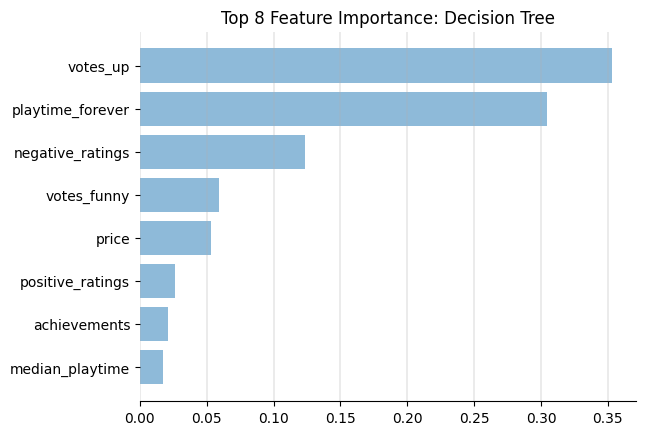

In [0]:
feat_imp = dict(zip(va.getInputCols(), dtmodel.featureImportances))
feat_imp = sorted(feat_imp.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)[:8]
feat_imp = dict(feat_imp)

plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = list(feat_imp.keys())
performance = list(feat_imp.values())
ax.barh(y_pos, performance,align='center',alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(axis='x',linewidth=0.35)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title("Top 8 Feature Importance: Decision Tree")
plt.show()

In [0]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# expects two input columns: prediction and label.

# f1|accuracy(default)|weightedPrecision|weightedRecall|weightedTruePositiveRate| 
# weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| 
# falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| 
# logLoss|hammingLoss
metric_name = "f1"

metrics = MulticlassClassificationEvaluator()\
                .setLabelCol("label")\
                .setPredictionCol("prediction")
metrics.setMetricName(metric_name) 

metrics.evaluate(dtpredicts)

CPU times: user 51.9 ms, sys: 17.3 ms, total: 69.2 ms
Wall time: 16.4 s
Out[12]: 0.8851198135869379

In [0]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator2 = MulticlassClassificationEvaluator()
print("Accuracy: " + str(evaluator.evaluate(dtpredicts, {evaluator2.metricName: "accuracy"})))

Accuracy: 0.7911766216967075
CPU times: user 18.2 ms, sys: 9.42 ms, total: 27.6 ms
Wall time: 5.06 s

In [0]:
%%time
# n-fold validation and the results.
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()\
                .setLabelCol("label")\
                .setPredictionCol("prediction")
#ParamGridBuilder() – combinations of parameters and their values.
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [5,10,15,20]).build()

cv = CrossValidator(estimator=dt, 
                    evaluator=evaluator, 
                    numFolds=5, 
                    estimatorParamMaps=paramGrid)

cvmodel = cv.fit(adulttrain)
dtpredicts = cvmodel.bestModel.transform(adultvalid)

print("Best Max Depth : %s" % cvmodel.bestModel.getMaxDepth)
print("Accuracy : %s" % evaluator.evaluate(dtpredicts))

Best Max Depth : <bound method _DecisionTreeParams.getMaxDepth of DecisionTreeClassificationModel: uid=DecisionTreeClassifier_c6dce7425939, depth=15, numNodes=31013, numClasses=2, numFeatures=6682>
Accuracy : 0.8922769050833781
CPU times: user 19.9 s, sys: 10.1 s, total: 30 s
Wall time: 2h 14min 16s

In [0]:
%%time
from pyspark.mllib.evaluation import MulticlassMetrics

#prediction and label
prediction_label = dtpredicts.select("prediction", "label").rdd

metrics = MulticlassMetrics(prediction_label)

confusionMetrics = metrics.confusionMatrix()

print("Confusion Metrics = \n%s" % confusionMetrics)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(
Confusion Metrics = 
DenseMatrix([[ 85214., 171116.],
 [ 39070., 1963084.]])
CPU times: user 267 ms, sys: 14.5 ms, total: 281 ms
Wall time: 7.86 s